In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Convolution2D, ELU, Dropout
from keras.models import Model, Sequential
from keras import backend
from keras import callbacks
from keras import optimizers
from keras.layers.core import SpatialDropout2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import cv2
import matplotlib.image as mpimg
from random import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import json
%matplotlib inline

Using TensorFlow backend.


In [2]:
tf.python.control_flow_ops = tf
backend.image_dim_ordering()

'tf'

In [3]:
def save_model(model, model_name):
    model.save_weights(model_name+".h5", True)
    with open(model_name+'.json', 'w') as outfile:
        json.dump(model.to_json(), outfile)

In [4]:
def make_model_vgg16():
    # vgg16
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    #Create input format
    input = Input(name = 'image_input', shape=(224,224,3))

    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(input)

    # freeze vgg16 conv layers
    for layer in model_vgg16_conv.layers:
        layer.trainable = False

    #model_vgg16_conv.summary()

    # Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = Dense(1, activation='linear', name='predicton_steering')(x)

    # Create model 
    return Model(input=input, output=x)

In [5]:
def make_model_nvidia():
    # based on this paper:
    # http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

    model = Sequential()
    
    model.add(Convolution2D(24, 5, 5, border_mode="valid", subsample=(2, 2), activation="elu", input_shape = (66,66,3)))
    model.add(Convolution2D(36, 5, 5, border_mode="valid", subsample=(2, 2), activation="elu"))
    model.add(Convolution2D(48, 5, 5, border_mode="valid", subsample=(2, 2), activation="elu"))
    model.add(Convolution2D(64, 3, 3, border_mode="valid", subsample=(1, 1), activation="elu"))
    model.add(Convolution2D(64, 3, 3, border_mode="valid", subsample=(1, 1), activation="elu"))
    model.add(Flatten(name='flatten')) 
    model.add(Dense(100, activation="elu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="elu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="elu"))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    
    # Create model
    return model

In [6]:
def make_model_commaai():
    model = Sequential()
    #model.add(Lambda(lambda x: x/127.5 - 1.,
    #        input_shape=(ch, row, col),
    #        output_shape=(ch, row, col)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", input_shape = (80,160,3)))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    #model.compile(optimizer="adam", loss="mse")
    return model


In [7]:
my_model=make_model_nvidia()
my_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 31, 31, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 14, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 5, 48)      43248       convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 3, 3, 64)      27712       convolution2d_3[0][0]            
___________________________________________________________________________________________

In [8]:
base_path = os.getcwd()

In [9]:
#log = pd.read_csv(base_path + '/data/udacity/data/' + 'driving_log.csv')
#log = log.drop(log[abs(log['steering']) < 0.1].index)
#log['steering']
#len(log)
#log[:3]
#log = log.drop(log[abs(log['throttle']) < 0.5].index)
#print(len(log))
#plt.plot(log['throttle'])

In [10]:
def preprocess_data_log(base_path, csv_file_name, split=0.1, col_name='center', steer_mod=0.0, flip_th=None):
    # read log file
    log = pd.read_csv(base_path + '/' + csv_file_name)
    
    # drop frames with low speed
    #log = log.drop(log[abs(log['throttle']) < 0.2].index)
    
    # drop rows base don flip_th
    if flip_th is None:
        flip = [0]*len(log)
    else:
        #log = log.drop(log[abs(log['steering']) < flip_th].index)
        flip = [1]*len(log)   
    
    # modify img file name column to contain the full path
    log[col_name] = log[col_name].str.replace('/Users/amakhlin/Documents/CarND/CarND-Behavioral-Cloning-Project/data/','')
    log[col_name] = base_path + '/' + log[col_name].str.lstrip()
    # extract img file names
    img_names = log[col_name].tolist()
    # extract angles
    angles = log['steering']   
    angles += steer_mod
    
    img_names_train, img_names_test, angles_train, angles_test = train_test_split(img_names, angles, test_size=split, random_state=42)
    
    return ( list(zip(img_names_train, angles_train, flip)), list(zip(img_names_test, angles_test, flip)) )

In [11]:
STEERING_CORRECTION_LEFT_RIGHT = 0.25

In [12]:
# Udacity dataset

# center images
train_data_list, test_data_list = preprocess_data_log(base_path + '/data/udacity/data', 'driving_log.csv')

# left images
train_data_list_l, test_data_list_l = preprocess_data_log(base_path + '/data/udacity/data', 'driving_log.csv',
                                                          col_name='left', steer_mod=STEERING_CORRECTION_LEFT_RIGHT)
# right images
train_data_list_r, test_data_list_r = preprocess_data_log(base_path + '/data/udacity/data', 'driving_log.csv',
                                                          col_name='right', steer_mod=-STEERING_CORRECTION_LEFT_RIGHT)

# center images to be flipped
#train_data_list_f, test_data_list_f = preprocess_data_log(base_path + '/data/udacity/data', 'driving_log.csv',
#                                                      flip_th=0.1)

# left images to be flipped
#train_data_list_l_f, test_data_list_l_f = preprocess_data_log(base_path + '/data/udacity/data', 'driving_log.csv',
#                                                         col_name='left', steer_mod=steer_mod, flip_th=0.1)

# right images to be flipped
#train_data_list_r_f, test_data_list_r_f = preprocess_data_log(base_path + '/data/udacity/data', 'driving_log.csv',
#                                                        col_name='right', steer_mod=-steer_mod, flip_th=0.1)

In [13]:
train_data_list = train_data_list +\
                    train_data_list_l +\
                    train_data_list_r# +\
                    #train_data_list_f +\
                    #train_data_list_l_f +\
                    #train_data_list_r_f


test_data_list = test_data_list +\
                    test_data_list_l +\
                    test_data_list_r# +\
                    #test_data_list_f +\
                    #test_data_list_l_f +\
                    #test_data_list_r_f

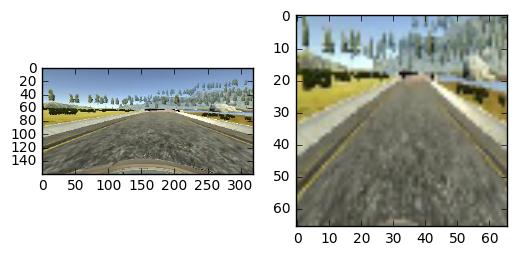

In [14]:
#log = pd.read_csv(base_path + '/data/smooth_track_x2/' + 'driving_log.csv')
log = pd.read_csv(base_path + '/data/udacity/data/' + 'driving_log.csv')

im = cv2.cvtColor(cv2.imread('data/udacity/data/'+log['center'][50]), cv2.COLOR_BGR2RGB)
#plt.figure(figsize=(12,20))
plt.subplot(1,2,1)
plt.imshow(im)
#im = cv2.flip(im, 1)
#im, _ = shift_image(im, 1)
im = im[34:-20,:,:]
im = cv2.resize(im, (66,66), interpolation=cv2.INTER_LINEAR)
plt.subplot(1,2,2)
plt.imshow(im)

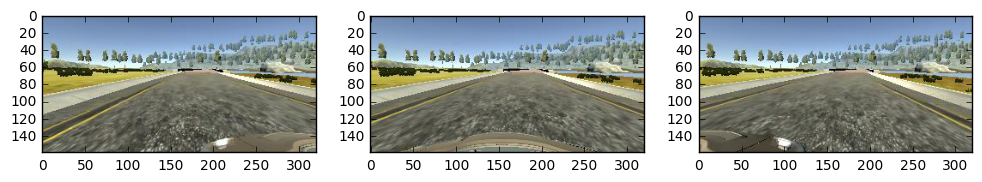

In [15]:
log = pd.read_csv('data/udacity/data/driving_log.csv')
imc = cv2.cvtColor(cv2.imread('data/udacity/data/'+log['center'][50]), cv2.COLOR_BGR2RGB)
iml = cv2.cvtColor(cv2.imread('data/udacity/data/'+(log['left'].str.strip())[50]), cv2.COLOR_BGR2RGB)
imr = cv2.cvtColor(cv2.imread('data/udacity/data/'+(log['right'].str.strip())[50]), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,20))
plt.subplot(1,3,1)
plt.imshow(iml)
plt.subplot(1,3,2)
plt.imshow(imc)
plt.subplot(1,3,3)
plt.imshow(imr)

# left/right camera shift corresponds to perhaps a few degrees of turn, I started with the assumption of 2 deg (0.08)
# eventually increased it to 3 deg (0.12)

In [16]:
def translate(img, tx, ty):
    rows,cols,_ = img.shape

    M = np.float32([[1,0,tx],[0,1,ty]])
    return cv2.warpAffine(img,M,(cols,rows))

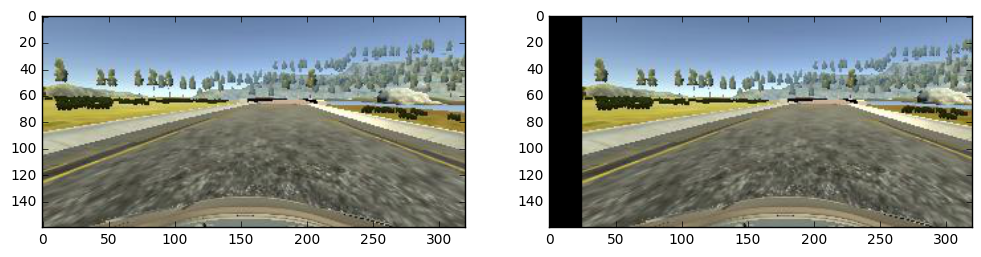

In [22]:
imc_shifted = translate(imc, 25, 0)
plt.figure(figsize=(12,20))
plt.subplot(1,2,1)
plt.imshow(imc)
plt.subplot(1,2,2)
plt.imshow(imc_shifted)

In [15]:
#train_data_list += tr + tr_f #tr + tr_l + tr_r + tr_f + tr_l_f + tr_r_f

#test_data_list += te + te_f #te + te_l + te_r + te_f + te_l_f + te_r_f

In [16]:
#train_data_list_f[200]

In [17]:
optimizer = optimizers.Adam(lr=0.001)
my_model.compile(optimizer, loss='mse')

In [18]:
def random_shift(im, ang, max_x_shift = 50, max_y_shift = 25, pixels_per_steering_unit = 25./STEERING_CORRECTION_LEFT_RIGHT):
    
    xp = int(np.random.uniform(-1,1) * max_x_shift)
    yp = int(np.random.uniform(-1,1) * max_y_shift)
        
    ang = ang + xp / pixels_per_steering_unit
    
    return translate(im, xp, yp), ang

In [20]:
def batch_gen(name, data_list, im_scale, batch_size, crop_top_px=0, crop_bot_px=0):
    # data_list is in this form: ['file_name', angle]
    # out_img_size is a shape of the output image: (x, y, color)
    im_h = 160
    im_w = 320
    #im_size = (int((im_h-crop_top_px-crop_bot_px)*im_scale), int(im_w*im_scale), 3)
    im_size = (66, 66, 3)
    
    
    # col & rows are reversed for cv2.resize
    #resize_shape = (out_img_size[1], out_img_size[0])
    
    # compensate for cropping
    #out_img_size = tuple(np.subtract(out_img_size, (crop_top_px+crop_bot_px, 0, 0)))
    
    # create batch_size np arrays as placeholders for imgages and angles
    X_train = np.empty((batch_size,) +  im_size, dtype = np.float64)
    y_train = np.empty(batch_size, dtype = np.float64)
    

    
    while True:
        # shuffle data
        shuffle(data_list)
        for offset in range(0, len(data_list), batch_size):
            end = offset + batch_size
            batch_subset = data_list[offset:end]
            for i, _ in enumerate(batch_subset):
                # load angle
                y_train[i] = batch_subset[i][1]
                
                #load image
                im = cv2.cvtColor(cv2.imread(batch_subset[i][0]), cv2.COLOR_BGR2RGB)
                #im = mpimg.imread(batch_subset[i][0])
                
                if name == 'train_gen':
                    # flip images randomly
                    if np.random.choice([True, False]):
                        #if batch_subset[i][2] == 1:
                        im = cv2.flip(im, 1)
                        y_train[i] *= -1.

                    # Randomly translate the image to the left or right
                    #im, y_train[i] = shift_image(im, y_train[i])
                    im, y_train[i] = random_shift(im, y_train[i])
                    
                # crop - img[y: y + h, x: x + w]
                #im = im[crop_top_px:(im_h-crop_bot_px),:,:]
                im = im[34:-20,:,:]
                    
                # resize and norm
                #X_train[i] = (cv2.resize(im, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_AREA).astype(np.float32))/254. - 0.5
                
                X_train[i] = (cv2.resize(im, (66,66), interpolation=cv2.INTER_LINEAR).astype(np.float64))/255. - 0.5
                

                
                #print(im_arr.shape)
                # crop - img[y: y + h, x: x + w]
                #print(im_arr.shape)
                # X_train[i]

                #X_train[i] = np.expand_dims(im, axis=0)
                
                
            batch_X, batch_y = X_train[:len(batch_subset)], y_train[:len(batch_subset)]
            #print(name)
            yield (batch_X, batch_y)

In [21]:
#g=batch_gen("train_gen", train_data_list, 0.5, 1, 40, 20)

In [22]:
#(im, a) = next(g)
#im.shape
#im = np.load('float_img.npy')
#plt.imshow(cv2.cvtColor(((im[0]+1)*128.).astype(np.uint8), cv2.COLOR_BGR2RGB))
#spplt.imshow(((im+1.)*128.).astype(np.uint8))
#plt.figure(figsize=(8,4))
#plt.imshow(((im[0]+0.5)*255.).astype(np.uint8))

In [23]:
#(im, a) = next(g)
len(train_data_list)

21696

In [24]:
len(test_data_list)

2412

In [25]:
#plt.imshow(cv2.cvtColor((im[0]*255.+128.).astype(np.uint8), cv2.COLOR_BGR2RGB))
#im0 = cv2.resize(cv2.imread(train_data_list[0][0]), (224, 224))
#plt.imshow(cv2.cvtColor(im0, cv2.COLOR_BGR2RGB))

In [26]:
train_gen = batch_gen("train_gen", train_data_list, 0.5, 64, 40, 20)
test_gen = batch_gen("test_gen", test_data_list, 0.5, 64, 40, 20)

In [27]:
checkpoint_path="nvidia-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=False, save_weights_only=True, mode='auto')

In [28]:
history = my_model.fit_generator(
    generator=train_gen, 
    validation_data=test_gen, 
    nb_val_samples=len(test_data_list), 
    samples_per_epoch=len(train_data_list), 
    nb_epoch=15,
    max_q_size=2,
    callbacks=[checkpoint])

Epoch 1/15
21696/21696 [==============================] - 41s - loss: 0.0854 - val_loss: 0.0442
Epoch 2/15
21696/21696 [==============================] - 39s - loss: 0.0716 - val_loss: 0.0525
Epoch 3/15
21696/21696 [==============================] - 39s - loss: 0.0638 - val_loss: 0.0364
Epoch 4/15
21696/21696 [==============================] - 39s - loss: 0.0582 - val_loss: 0.0316
Epoch 5/15
21696/21696 [==============================] - 39s - loss: 0.0535 - val_loss: 0.0350
Epoch 6/15
21696/21696 [==============================] - 39s - loss: 0.0518 - val_loss: 0.0337
Epoch 7/15
21696/21696 [==============================] - 39s - loss: 0.0496 - val_loss: 0.0304
Epoch 8/15
21696/21696 [==============================] - 39s - loss: 0.0486 - val_loss: 0.0356
Epoch 9/15
21696/21696 [==============================] - 39s - loss: 0.0481 - val_loss: 0.0294
Epoch 10/15
21696/21696 [==============================] - 39s - loss: 0.0482 - val_loss: 0.0283
Epoch 11/15
21696/21696 [==============

In [29]:
save_model(my_model, 'nvidia')

In [30]:
history = my_model.fit_generator(
    generator=train_gen, 
    validation_data=test_gen, 
    nb_val_samples=len(test_data_list), 
    samples_per_epoch=len(train_data_list), 
    nb_epoch=5,
    max_q_size=2,
    callbacks=[checkpoint])

Epoch 1/5
21696/21696 [==============================] - 39s - loss: 0.0439 - val_loss: 0.0268
Epoch 2/5
21696/21696 [==============================] - 39s - loss: 0.0440 - val_loss: 0.0287
Epoch 3/5
21696/21696 [==============================] - 39s - loss: 0.0430 - val_loss: 0.0280
Epoch 4/5
21696/21696 [==============================] - 39s - loss: 0.0434 - val_loss: 0.0256
Epoch 5/5
21696/21696 [==============================] - 39s - loss: 0.0427 - val_loss: 0.0258


In [ ]:
save_model(my_model, 'nvidia')